In [1]:
from torchvision.datasets import Cityscapes
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from typing import Any, Callable, Dict, List, Optional, Union, Tuple
from torchvision.datasets import Cityscapes

In [2]:
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint,LearningRateMonitor
import segmentation_models_pytorch as smp

In [3]:
from pytorch_lightning import seed_everything, LightningModule, Trainer
import multiprocessing
import torchmetrics
import torch

In [4]:
base_path = "cityscapes_format_animal_gta/gtFine/val/aachen/"
for f in os.listdir(base_path):
    c = f.replace("__","_")
    os.rename(os.path.join(base_path,f),os.path.join(base_path,c))

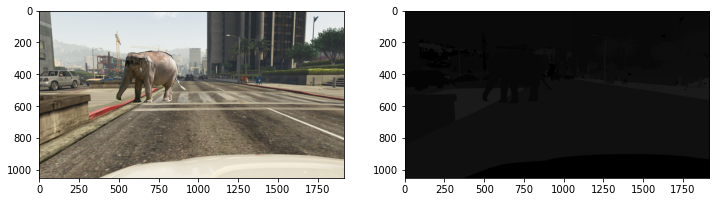

In [5]:
dataset = Cityscapes('cityscapes_format_animal_gta/', split='train', mode='fine',target_type='semantic')
fig,ax=plt.subplots(ncols=2,figsize=(12,8))
ax[0].imshow(dataset[10][0])
ax[1].imshow(dataset[10][1],cmap='gray')

In [6]:
df = pd.read_csv('class_dict_seg.txt')
classes = df['name']
palette = df[['r', 'g', 'b']].values
id2label = classes.to_dict()
label2id = {k:list(v) for k, v in enumerate(palette)}
label_colours = label2id
label_colours
n_classes= len(label_colours)

In [7]:
colors = [   [  0,   0,   0],
        [128, 64, 128],
        [244, 35, 232],
        [70, 70, 70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170, 30],
        [220, 220, 0],
        [107, 142, 35],
        [152, 251, 152],
        [0, 130, 180],
        [220, 20, 60],
        [255, 0, 0],
        [0, 0, 142],
        [0, 0, 70],
        [0, 60, 100],
        [0, 80, 100],
        [0, 0, 230],
        [119, 11, 32],
    ]

label_colours = dict(zip(range(n_classes), colors))

In [8]:
def encode_segmap(mask):

    if mask.shape[-1] ==3:
        return mask[:,:,0]
    else:
        return mask
    return mask[:,:,0]

def decode_segmap(temp):
    temp=temp.numpy()
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0, n_classes):
        r[temp == l] = label_colours[l][0]
        g[temp == l] = label_colours[l][1]
        b[temp == l] = label_colours[l][2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    return rgb


In [9]:
transform=A.Compose(
[
    A.Resize(256, 512),
    A.HorizontalFlip(),
    ToTensorV2(),
]
)

In [10]:
class Tranform_Data(Cityscapes):
    def __getitem__(self, index):
        image = Image.open(self.images[index]).convert('RGB')

        targets: Any = []
        for i, t in enumerate(self.target_type):
            target = Image.open(self.targets[index][i])
            targets.append(target)
            
        target = tuple(targets) if len(targets) > 1 else targets[0]

        if self.transforms is not None:
            transformed=transform(image=np.array(image), mask=np.array(target))            
        return transformed['image'],transformed['mask'][:,:,0]


In [11]:
dataset=Tranform_Data('cityscapes_format_animal_gta/', split='val', mode='fine',target_type='semantic',transforms=transform)

In [12]:
class UNet(LightningModule):
  def __init__(self):
    super(UNet,self).__init__()
    #architecute
    self.layer = smp.Unet(
                encoder_name="resnet34",      
                encoder_weights="imagenet",     
                in_channels=3,                  
                classes=n_classes,                    
            )

    self.lr=1e-3
    self.batch_size=16
    self.numworker=multiprocessing.cpu_count()//4


    self.criterion= smp.losses.DiceLoss(mode='multiclass')
    self.metrics = torchmetrics.JaccardIndex(task="multiclass", num_classes=n_classes)
    
    self.train_class = Tranform_Data('cityscapes_format_animal_gta/', split='train', mode='fine',
                     target_type='semantic',transforms=transform)
    self.val_class = Tranform_Data('cityscapes_format_animal_gta/', split='val', mode='fine',
                     target_type='semantic',transforms=transform)
    
    
  def process(self,image,segment):
    out=self(image)
    segment=encode_segmap(segment)
    loss=self.criterion(out,segment.long())
    iou=self.metrics(out,segment)
    return loss,iou
    
  def forward(self,x):
    return self.layer(x)


  def configure_optimizers(self):
    opt=torch.optim.AdamW(self.parameters(), lr=self.lr)
    return opt

  def train_dataloader(self):
    return DataLoader(self.train_class, batch_size=self.batch_size, 
                      shuffle=True,pin_memory=True,num_workers=self.numworker)

  def training_step(self,batch,batch_idx):
    image,segment=batch
    loss,iou=self.process(image,segment)
    self.log('train_loss', loss,on_step=False, on_epoch=True,prog_bar=True)
    self.log('train_iou', iou,on_step=False, on_epoch=True,prog_bar=False)
    return loss

  def val_dataloader(self):
    return DataLoader(self.val_class, batch_size=self.batch_size, 
                      shuffle=False,pin_memory=True,num_workers=self.numworker)
    
  def validation_step(self,batch,batch_idx):
    image,segment=batch
    loss,iou=self.process(image,segment)
    self.log('val_loss', loss,on_step=False, on_epoch=True,prog_bar=False)
    self.log('val_iou', iou,on_step=False, on_epoch=True,prog_bar=False)
    return loss

In [13]:
model = UNet()
checkpoint_callback = ModelCheckpoint(monitor='val_loss',dirpath='checkpoints',filename='file',save_last=True)

In [14]:
os.environ['SLURM_NTASKS']='1'
#os.environ['SLURM_TASKS_PER_NODE']='16'

In [15]:
#trainer = Trainer(max_epochs=10,precision=16,callbacks=[checkpoint_callback],num_nodes=1)
trainer = Trainer(max_epochs=50,callbacks=[checkpoint_callback],devices=1, accelerator="gpu",num_nodes=1,precision='32')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [16]:
trainer.fit(model)


You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/uufs/chpc.utah.edu/common/home/u1419864/.local/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /scratch/general/vast/u1419864/cv/Final project/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | layer     | Unet                   | 24.4 M
1 | criterion | DiceLoss               | 0     
2 | metrics   | MulticlassJaccardIndex | 0     
----------------------------

Sanity Checking: 0it [00:00, ?it/s]

RuntimeError: Input type (torch.cuda.ByteTensor) and weight type (torch.cuda.FloatTensor) should be the same

In [ ]:
#torch.save(model.state_dict(), 'unet_gta.pth')
model.load_state_dict(torch.load('unet_gta.pth'))

In [ ]:
test_class = MyClass('cityscapes_format_animal_gta/', split='val', mode='fine',
                     target_type='semantic',transforms=transform)
test_loader=DataLoader(test_class, batch_size=12, 
                      shuffle=False)

In [ ]:
model=model.cuda()
model.eval()
with torch.no_grad():
    for batch in test_loader:
        img,seg=batch
        output=model(img.cuda())
        break
print(img.shape,seg.shape,output.shape)    

In [ ]:
from torchvision import transforms
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.255]
)


In [ ]:

sample=6
invimg=inv_normalize(img[sample])
outputx=output.detach().cpu()[sample]
encoded_mask=encode_segmap(seg[sample].clone()) #(256, 512)
decoded_mask=decode_segmap(encoded_mask.clone())  #(256, 512)
decoded_ouput=decode_segmap(torch.argmax(outputx,0))
fig,ax=plt.subplots(ncols=3,figsize=(16,50),facecolor='white')  
ax[0].imshow(np.moveaxis(invimg.numpy(),0,2)) #(3,256, 512)
#ax[1].imshow(encoded_mask,cmap='gray') #(256, 512)
ax[1].imshow(decoded_mask) #(256, 512, 3)
ax[2].imshow(decoded_ouput) #(256, 512, 3)
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[0].set_title('Input Image')
ax[1].set_title('Ground mask')
ax[2].set_title('Predicted mask')
#plt.savefig('result.png',bbox_inches='tight')